# Advanced Lane Finding

The goal of this project is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.

## Initialization

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob
%matplotlib inline

## Camera calibration

In [2]:
def find_corners(images,nx,ny):
    '''
    images: list of images 
    nx: the number of inside corners in x
    ny: the number of inside corners in y
    return object and image points lists
    '''
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        
        
    return objpoints,imgpoints

def cal_undistort(img, objpoints, imgpoints):
    '''
    img: input image
    objpoints: list of 3d points in real world space
    imgpoints: list of 2d points in image plane 
    return undistorted image, camera matrix, distortion coeficient
    '''
    
    # convert to gray
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #Camera calibration, given object points, image points, and the shape of the grayscale image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    #Undistorting a image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        
    return undist, mtx, dist



def corners_unwarp(img, nx, ny, mtx, dist):
    '''
    function corners_unwarp from the lesson Camera Calibration
    img: input image
    nx: the number of inside corners in x
    ny: the number of inside corners in y
    mtx: camera matrix
    dist: distortion coeficient
    '''
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M


In [3]:
nx = 9 # number of inside corners in x
ny = 5 # number of inside corners in y
images=glob.glob('camera_cal/calibration*.jpg') # list of chessboard images

In [4]:
#Finding chessboard corners
objpoints, imgpoints = find_corners(images,nx,ny)

In [5]:
#test image
test_img = mpimg.imread('camera_cal/calibration1.jpg')
# Undistorting a test image
undistorted,mtx,dist = cal_undistort(test_img,objpoints,imgpoints)


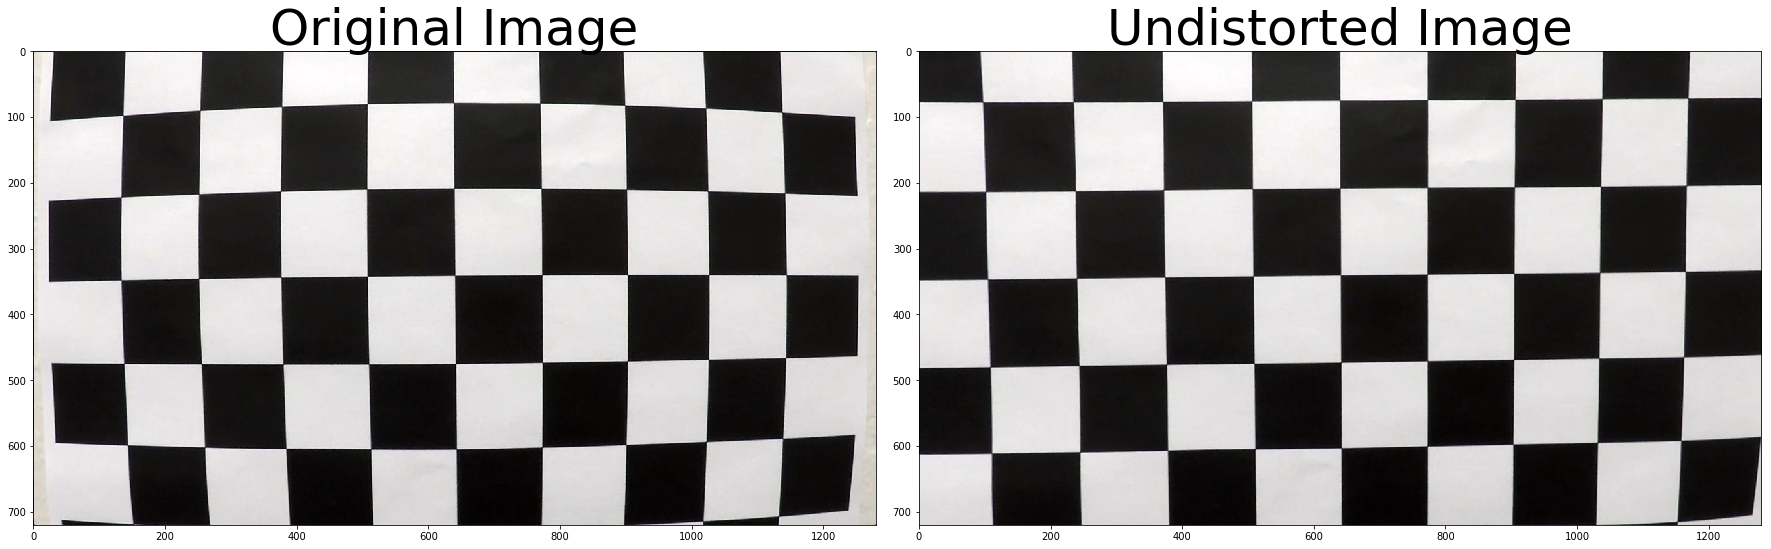

In [6]:
#plot test and undisorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)